# Self-supervised

This example shows how to train a neural operator on sine functions
in a self-supervised manner.

## Setup

Import modules.

In [1]:
import torch
import matplotlib.pyplot as plt
from continuity.data.datasets import Sine
from continuity.data import SelfSupervisedDataSet
from continuity.operators import ContinuousConvolution
from continuity.operators.common import NeuralNetworkKernel
from continuity.plotting import plot_evaluation, plot

In [2]:
torch.manual_seed(1)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0


## Dataset

Create a data set of sine waves: The `Sine` dataset generates $N$ sine waves
$$
f(x) = \sin(w_k x), \quad w_k = 1 + \frac{k}{N-1},
$$
$$
\quad k = 0, \dots, N-1.
$$
We wrap the `Sine` dataset by a `SelfSupervisedDataset` that exports batches
of samples for self-supervised training, namely
$$
\left(\mathbf{x}, f(\mathbf{x}), x_j, f(x_j)\right), \quad \text{for } j = 1, \dots, M,
$$
where $\mathbf{x} = (x_i)_{i=1 \dots M}$ are the $M$ equidistantly
distributed sensor positions.

Dataset contains 32 batches.


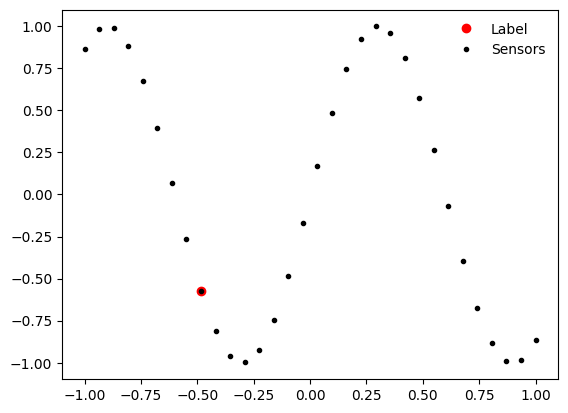

In [3]:
size = 4
sine = Sine(
    num_sensors=32,
    size=size,
)
# Create self-supervised dataset
dataset = SelfSupervisedDataSet(
    sine.x,
    sine.u,
    batch_size=4,
    shuffle=True,
)
print(f"Dataset contains {len(dataset)} batches.")

# Plot first sample
first_batch = dataset[0]
x, u, y, v = [a[0] for a in first_batch]
plt.plot(y, v, 'ro', label='Label')
plt.plot(x, u, 'k.', label='Sensors')
plt.legend()
plt.show()

## Operator

We use a `ContinuousConvolution` neural operator with a slightly overparameterized
`NeuralNetworkKernel` as kernel function.

In [4]:
kernel = NeuralNetworkKernel(kernel_width=128, kernel_depth=10)
model = ContinuousConvolution(kernel)

## Training

Train the neural operator.

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.compile(optimizer)
model.fit(dataset, epochs=100)

Model parameters: 165505
Epoch 100:  loss = 3.6071e-03  (230.95 it/s)


## Plotting

Plot model predictions for training data.

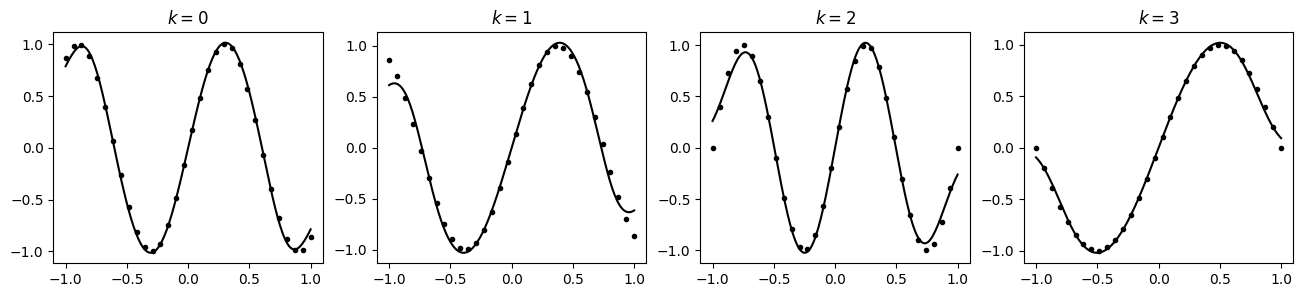

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(16, 3))
x, u, y, v = dataset[0] # First batch
for i in range(size):
    plot_evaluation(model, x[i], u[i], ax=axs[i])
    plot(x[i], u[i], ax=axs[i])
    axs[i].set_title(f"$k = {i}$")

# Generalization

Plot prediction on a test sample which was not part of the training set.

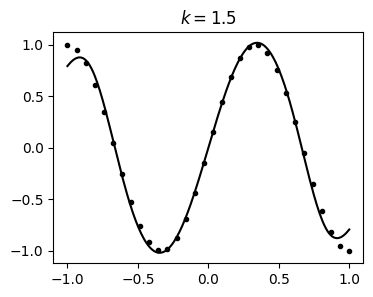

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
i_test = (size-1) / 2

x, u = sine.generate_observation(i_test)
plot_evaluation(model, x, u, ax=ax)
plot(x, u, ax=ax)
ax.set_title(f"$k = {i_test}$")
plt.show()